In [1]:
%run ./"0 Imports and functions.ipynb"

# Load cube information 

File_Descriptor="cmz_3mm_HCO+_J1-0_"

##################################

import pickle 

with open("Spectral Cubes/Cube Information/"+File_Descriptor+"_Cube_Information", 'rb') as file:
    
    Cube_Information = pickle.load(file)
    
with open("Spectral Cubes/Cube Information/"+File_Descriptor+"_Pointing_Information", 'rb') as file:
    
    Pointing_Information = pickle.load(file)
    

print(Cube_Information)

#Cube_Information['spatial_scale'] = np.sqrt(Cube_Information['arc_per_pix_x']*Cube_Information['arc_per_pix_y'])*u.pix

#%matplotlib widget 
#%matplotlib notebook


/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
spectral_cube 0.6.1.dev22+g003ef16
spectral_cube file path /home/ben/.local/lib/python3.8/site-packages/spectral_cube/__init__.py
reproject 0.8
1.23.1 Numpy
astrodendro_file: /home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py
Results will be saved to Directory ./Result Files
Cubes will be saved and loaded with Directory ./Spectral Cubes
Plots will be saved to Directory ./Plots
Dendrograms will be saved to Directory ./Dendrograms
{'Original_File_Name': 'CMZ_3mm_HCO+.fits', 'File_Descriptor': 'cmz_3mm_HCO+_J1-0_', 'target': 'CMZ', 'center': <SkyCoord (Galactic): (l, b) in deg
    (359.94423333, -0.04616)>, 'crop_center': <SkyCoord (Galactic): (l, b) in deg
    (0.50833333, -0.04616)>, 'distance': <Quantity 0.008178 Mpc>, 'target_image_rotation': <Quantity 0. deg>, 'target_inclination

# 3a. Analyze the dendrogram

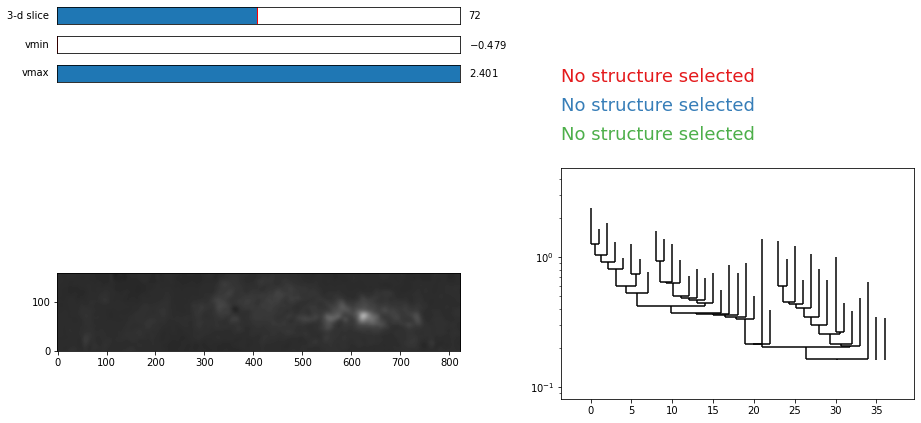

In [2]:

File_Name = Cube_Information['File_Name']
Dend_Name=File_Name[0:len(File_Name)-5]+"_Dendrogram" # The saving convention for the dendrograms

Dendrogram = astrodendro.Dendrogram.load_from('Dendrograms/'+Dend_Name)
# Show the dendrogram
p1 = Dendrogram.plotter() 
v1 = Dendrogram.viewer()
v1.show()

# 3b. Structure Statistics.

In [3]:
# Load dendrogram and cubes
File_Name = Cube_Information['File_Name']
Dend_Name=File_Name[0:len(File_Name)-5]+"_Dendrogram" # The saving convention for the dendrograms

Dendrogram = astrodendro.Dendrogram.load_from('Dendrograms/'+Dend_Name)
SC = SpectralCube.read("Spectral Cubes/"+File_Name).with_spectral_unit(u.km/u.s,velocity_convention="radio") 

# Re update teh continuum cube
pathCont = Cube_Information["Corresponding_Continuum_Reprojected"]
scCont = spectral_cube.Projection.from_hdu(fits.open("Spectral Cubes/"+pathCont)) # {Why was there a  [0] here?}

try:
    BUNIT = scCont.unit
    print("The continuum has unit",BUNIT)
    scCont = scCont.to(u.Jy/u.beam) #Fails if unitless
    BUNIT = scCont.unit
    print("Change to:",BUNIT)
    print("verify unit length is non zero, length = ",len(str(BUNIT)),str(BUNIT)) #Fails if there is no unit

except:
    print("The continuum is unitless; unit defaults to Jy/beam")
    scCont = scCont*u.Jy/u.beam #Some data was taken before BUNIT were implemented, but they are in Jy/beam
        
Use_Dict = {'desired_beam_oversampling': "NA"} # this is irrelevant since the continuum is higher resolution than the data cubes
Use_Dict["distance"] = Cube_Information["distance"] # same as for the data cube
Continuum_Information = Update_Cube_Information(Use_Dict,pathCont)
    
    
    
# usage: def Dendrogram_Stats(Dendrogram,Cube,Continuum_Cube,Continuum_Information,Cube_Information,Trunks=True,min_size=0*u.pc,max_size=18*u.pc,edge_cases=False,distance_calculation=False):

# Calculate the statistics from the function:
# The stats are in arrays, [[Leaves],[Branches]]
#Size,RMS_Velocity,V_rms_err,Luminosity,CDs,SIDs,MOM0_FLUX,Distances = Dendrogram_Stats(Dendrogram,SC,scCont,Continuum_Information,Cube_Information,Trunks=True,edge_cases=True)
Size,RMS_Velocity,V_rms_err,Luminosity,CDs,SIDs,MOM0_FLUX,Distances = Dendrogram_Stats(Dendrogram,SC,scCont,Continuum_Information,Cube_Information,Trunks=True,edge_cases=False,min_size=1.0*u.pc)

#Save the result files

import pickle 

File_Name = Cube_Information['File_Name']

Results = [Size,RMS_Velocity,V_rms_err,Luminosity,CDs,SIDs,MOM0_FLUX,Distances]

with open("Result Files/"+File_Name[0:len(File_Name)-5]+"_Results", 'wb') as file:
    pickle.dump(Results, file)
    

print("good")

The continuum has unit Jy / beam
Change to: Jy / beam
verify unit length is non zero, length =  9 Jy / beam
good


In [4]:
#print(Size,RMS_Velocity,V_rms_err,Luminosity,CDs,SIDs,MOM0_FLUX,Distances)
print(np.shape(Size))
print(len(Size[0]),len(Size[1]))
#print(Results)

(2,)
37 20


# 3c. Analyze Statistics

In [5]:

Size,RMS_Velocity,V_rms_err,Luminosity,CDs,SIDs,MOM0_FLUX,Distances = Results

print("Size in ", Size[0][0].unit,"Sigma in",RMS_Velocity[0][0].unit,"Luminosity in",Luminosity[0][0].unit,"CD in",CDs[0][0].unit,'Mom 0 in',MOM0_FLUX[0][0].unit )


#Split the arrays, and strip teh units so i can plot them:

def strip_units(quantity_list):
    return [q.value for q in quantity_list]

# Convert each to unitless lists
Size_Leaves, Size_Branches, Size_All = strip_units(Size[0]), strip_units(Size[1]), (np.concatenate((strip_units(Size[0]), strip_units(Size[1]))))
RMS_Velocity_Leaves, RMS_Velocity_Branches, RMS_Velocity_All = strip_units(RMS_Velocity[0]), strip_units(RMS_Velocity[1]), (np.concatenate((strip_units(RMS_Velocity[0]), strip_units(RMS_Velocity[1]))))
V_rms_err_Leaves, V_rms_err_Branches, V_rms_err_All = strip_units(V_rms_err[0]), strip_units(V_rms_err[1]), (np.concatenate((strip_units(V_rms_err[0]), strip_units(V_rms_err[1]))))
Luminosity_Leaves, Luminosity_Branches, Luminosity_All = strip_units(Luminosity[0]), strip_units(Luminosity[1]), (np.concatenate((strip_units(Luminosity[0]), strip_units(Luminosity[1]))))
CDs_Leaves, CDs_Branches, CDs_All = strip_units(CDs[0]), strip_units(CDs[1]), (np.concatenate((strip_units(CDs[0]), strip_units(CDs[1]))))
SIDs_Leaves, SIDs_Branches, SIDs_All = (SIDs[0]), (SIDs[1]), (np.concatenate((SIDs[0], SIDs[1])))
MOM0_FLUX_Leaves, MOM0_FLUX_Branches, MOM0_FLUX_All = strip_units(MOM0_FLUX[0]), strip_units(MOM0_FLUX[1]), (np.concatenate((strip_units(MOM0_FLUX[0]), strip_units(MOM0_FLUX[1]))))
"""

Size_Leaves,Size_Branches,Size_All =                                                         Size[0],Size[1],np.concatenate((Size[0],Size[1]))
RMS_Velocity_Leaves,RMS_Velocity_Branches,RMS_Velocity_All = RMS_Velocity[0],RMS_Velocity[1],np.concatenate((RMS_Velocity[0],RMS_Velocity[1]))
V_rms_err_Leaves,V_rms_err_Branches,V_rms_err_All =                      V_rms_err[0],V_rms_err[1],np.concatenate((V_rms_err[0],V_rms_err[1]))
Luminosity_Leaves,Luminosity_Branches,Luminosity_All =               Luminosity[0],Luminosity[1],np.concatenate((Luminosity[0],Luminosity[1]))
CDs_Leaves,CDs_Branches,CDs_All =                                                                CDs[0],CDs[1],np.concatenate((CDs[0],CDs[1]))
SIDs_Leaves,SIDs_Branches,SIDs_All =                                                         SIDs[0],SIDs[1],np.concatenate((SIDs[0],SIDs[1]))
MOM0_FLUX_Leaves,MOM0_FLUX_Branches,MOM0_FLUX_All =                      MOM0_FLUX[0],MOM0_FLUX[1],np.concatenate((MOM0_FLUX[0],MOM0_FLUX[1]))

print("Size in ", Size_Leaves.unit,"Sigma in",RMS_Velocity_Leaves.unit,"Luminosity in",Luminosity_Leaves.unit,"CD in",CDs_Leaves.unit,'Mom 0 in',MOM0_FLUX_Leaves.unit )

#remove the units so i can plot them as floats
Size_Leaves,Size_Branches,Size_All =                                                 Size_Leaves/Size_Leaves[0][0].unit,Size_Branches/Size_Leaves[0][0].unit,Size_All
RMS_Velocity_Leaves,RMS_Velocity_Branches,RMS_Velocity_All = RMS_Velocity_Leaves/RMS_Velocity_Leaves[0][0].unit,RMS_Velocity_Branches/RMS_Velocity_Leaves[0][0].unit,RMS_Velocity_All
V_rms_err_Leaves,V_rms_err_Branches,V_rms_err_All =                   V_rms_err_Leaves/V_rms_err_Leaves[0][0].unit,V_rms_err_Branches/V_rms_err_Leaves[0][0].unit,V_rms_err_All
Luminosity_Leaves,Luminosity_Branches,Luminosity_All =             Luminosity_Leaves/Luminosity_Leaves[0][0].unit,Luminosity_Branches/Luminosity_Leaves[0][0].unit,Luminosity_All
CDs_Leaves,CDs_Branches,CDs_All =                                                       CDs_Leaves/CDs_Leaves[0][0].unit,CDs_Branches/CDs_Leaves[0][0].unit,CDs_All
MOM0_FLUX_Leaves,MOM0_FLUX_Branches,MOM0_FLUX_All =                   MOM0_FLUX_Leaves/MOM0_FLUX_Leaves[0][0].unit,MOM0_FLUX_Branches/MOM0_FLUX_Leaves[0][0].unit,MOM0_FLUX_All

"""

nth = 0# sorted(CD[0])[len(CD[0])-20]

pc_per_pixel = Cube_Information["spatial_scale_x"]
sig_per_pixel= Cube_Information["velocity_scale"] #np.nan#metadata['spectral_resolution']/u.pix


#Do a curve fit of the data

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

#Define the form of the function for the curve_fit
def func(R,a,b):
    return a*R**(b)

'''
#determine the size-linewidth:
#(if there is not enough data, there will be an error, so i put nan values)

try:
    #Leaves
    popt, pcov = curve_fit(func, Size_Leaves,RMS_Velocity_Leaves) # The fit matrix and the covariance matrix (which gives the error on the fit)
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    #branches
    poptB, pcovB = curve_fit(func,  Size_Branches,RMS_Velocity_Branches) 
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    #leaves and branches
    popt_All, pcov_All = curve_fit(func,  Size_All,RMS_Velocity_All)
except:
    popt_All, pcov_All = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
'''
#determine the size-linewidth:
#(if there is not enough data, there will be an error, so i put nan values)

#Leaves
popt, pcov = curve_fit(func, Size_Leaves,RMS_Velocity_Leaves) # The fit matrix and the covariance matrix (which gives the error on the fit)

#branches
poptB, pcovB = curve_fit(func,  Size_Branches,RMS_Velocity_Branches) 

#leaves and branches
popt_All, pcov_All = curve_fit(func,  Size_All,RMS_Velocity_All)



#Radius Luminosity fit
#Good pixels are places where the luminosity (and, therefore, column density) are above zero

gp = np.where(Luminosity_All>0)
lgp = Luminosity_All[gp]
radgp = Size_All[gp]

gp2 = np.where(CDs_All>0)
cgp = CDs_All[gp2]
rgp = RMS_Velocity_All[gp2]**2/Size_All[gp2]

radgpFORRAT = Size_All[gp2]
siggpFORRAT = RMS_Velocity_All[gp2]
lumFORRAT = Luminosity_All[gp2]
mom0FORRAT = MOM0_FLUX_All[gp2]


RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)


#Column density to Size-linewidth
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)


# Make luminosity-SL ratio plots (for finding boundary conditions from the assumed mass)

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]
gp4=np.where(MOM0_FLUX_All>0)
mom0FORFlux=MOM0_FLUX_All[gp4]
radgpFORFlux=Size_All[gp4]
rgpFORFlux=RMS_Velocity_All[gp4]**2/Size_All[gp4]






Size in  pc Sigma in km / s Luminosity in erg / (Hz s) CD in 1 / cm2 Mom 0 in K km / s


# 3x. Save fit results

In [6]:

popt[0],popt[1],poptB[0],poptB[1],popt_All[0],popt_All[1]

SL_Fits = [[popt,pcov],[poptB,pcovB],[popt_All,pcov_All]]
RL_Fits = [RLpopt,RLpcov]
CD_SL_Ratio = [CDpopt,CDpcov]
  


# The fits, each fit has the [popt,pcov], (the fit and covariance matrix)
Fit_Results=SL_Fits,RL_Fits,CD_SL_Ratio #Fits: [[Size_Linewidth_Leaves,Size_Linewidth_Branches,Size_Linewidth_All],[Radius_Luminosity_All],[CD_SL-Ratio]]

import pickle 

File_Name = Cube_Information['File_Name']

with open("Result Files/"+File_Name[0:len(File_Name)-5]+"_Fit_Results", 'wb') as file:
    pickle.dump(Fit_Results, file)

# x. make some plots

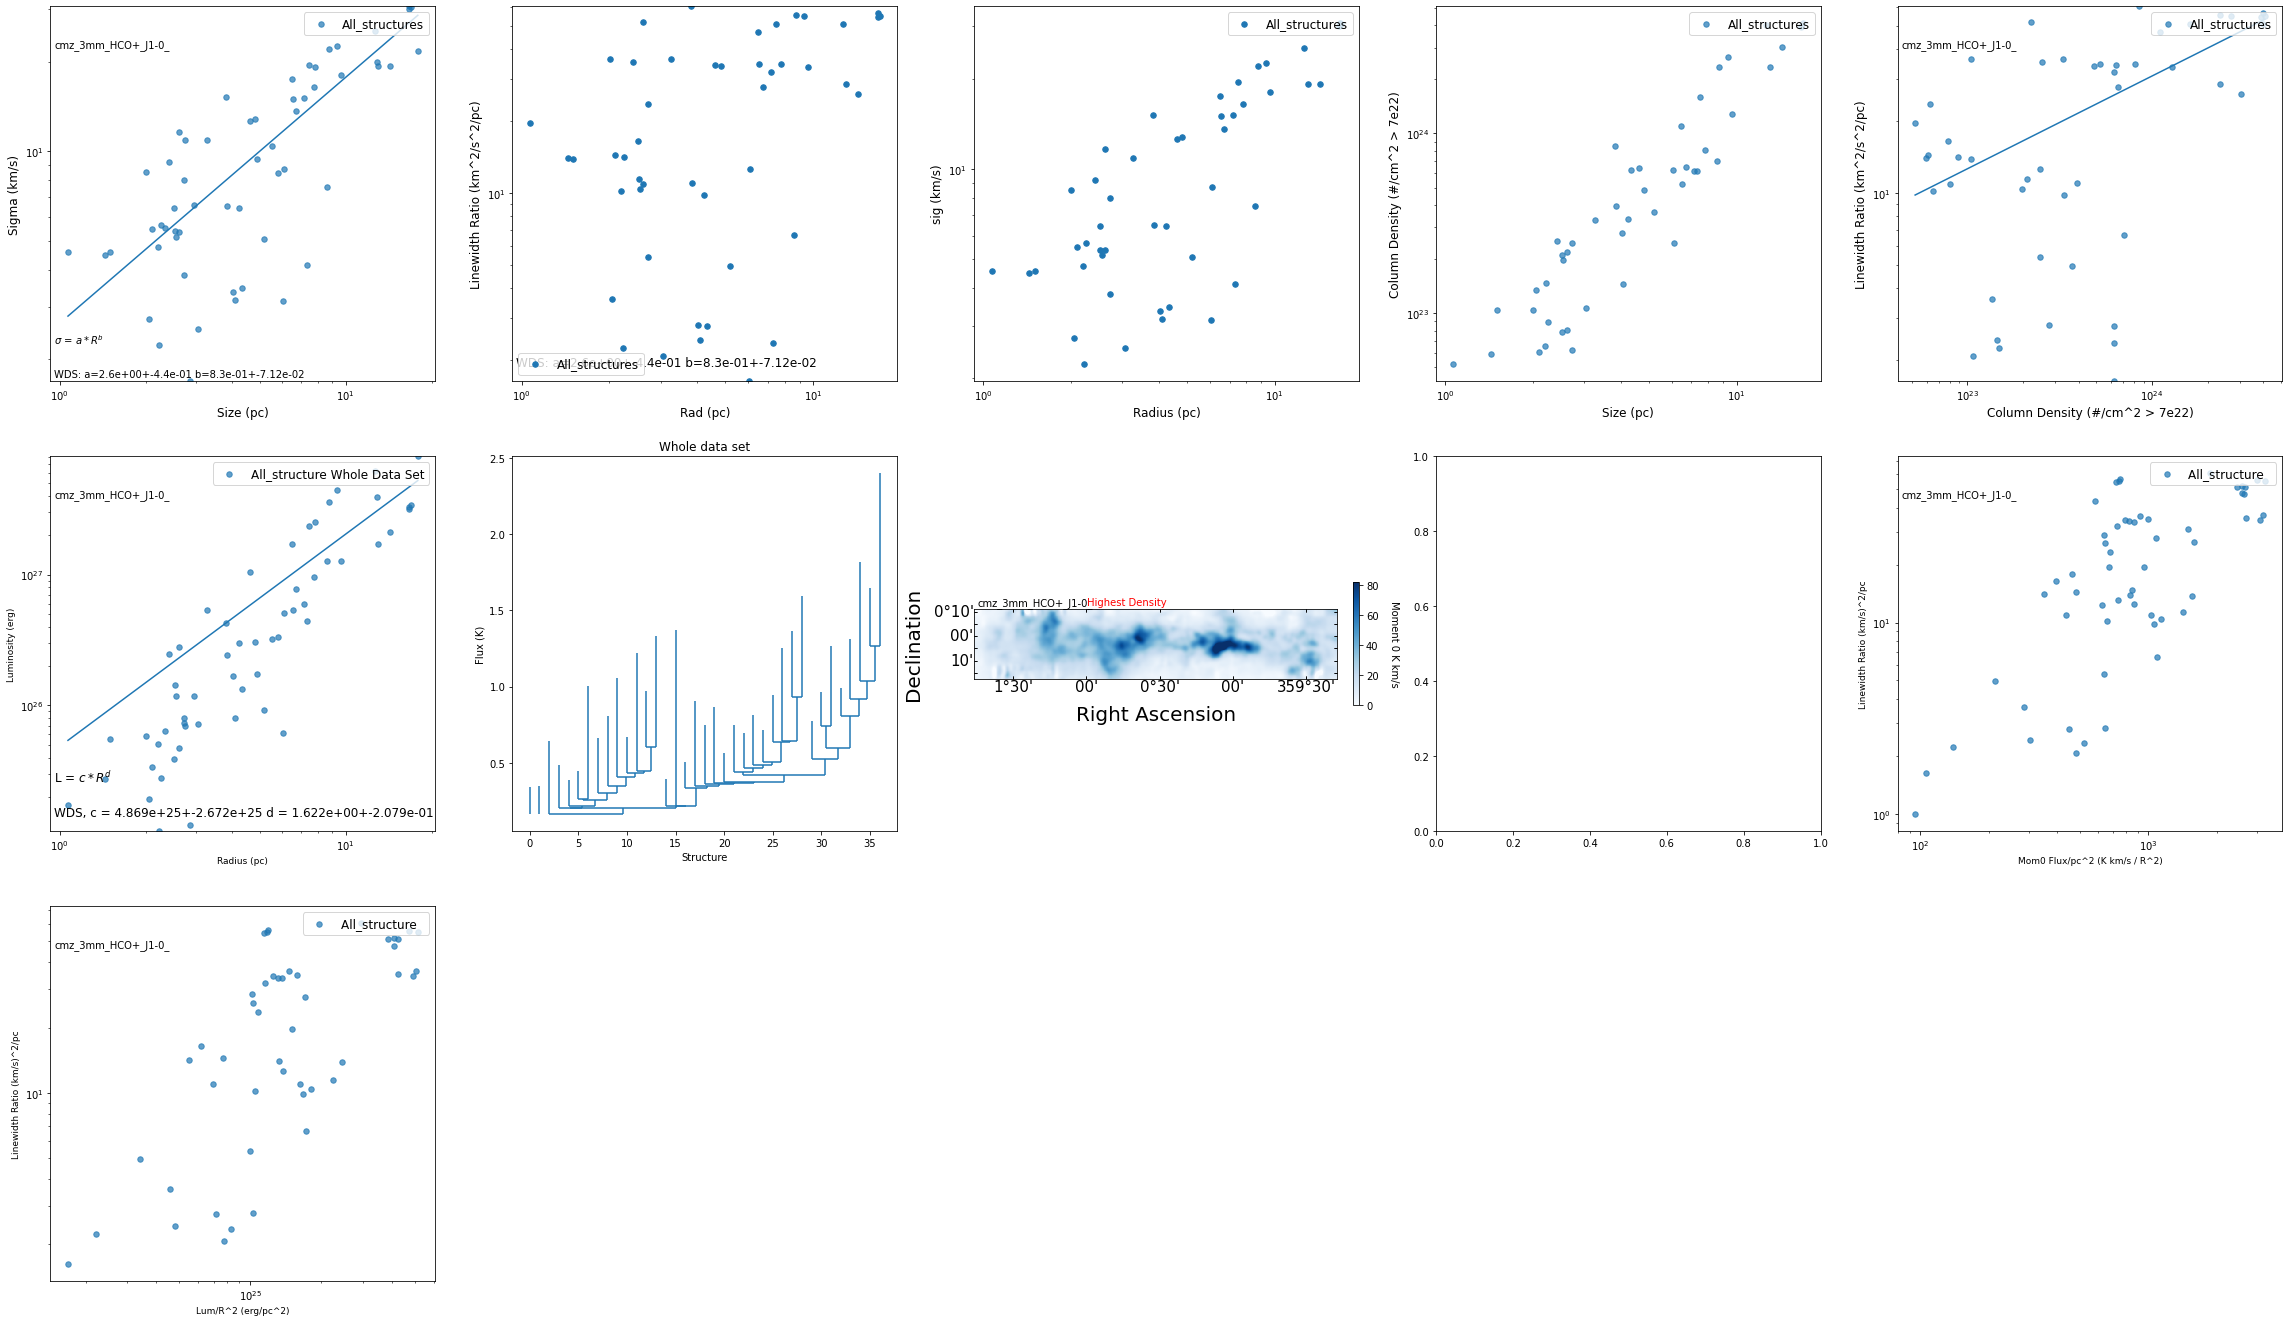

In [7]:
# Plot contours for the top ten clusters

fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)







p1=Dendrogram.plotter()
p1.plot_tree(axAlpha)

axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")



SC_moment0 =SC.moment0()
'''
bp = np.where(CDs<=7*10**22/u.cm**2)
bp2 = np.where(SC_moment0.hdu.data < (np.nanstd(SC_moment0.hdu.data,where= ((SC_moment0.hdu.data>0)  | (SC_moment0.hdu.data<0) )))) # below the Noise (K km/s)

SC_moment0.hdu.data[bp2]=np.nan


scCropped.hdu.data[bp]=np.nan

'''

axDelta = pylab.subplot(5,5,8,projection=SC_moment0.wcs)


imBeta = axDelta.imshow(SC_moment0.hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(SC_moment0.hdu.data)*.7 )


G1 = True

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]






RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=File_Descriptor,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  





# Make a line showing each of the fits (SL fit):

xs=np.linspace(np.nanmin(Size_All),np.nanmax(Size_All),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,popt_All[0],popt_All[1])

# Make a line showing the fits (RAD-LUM fit):

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

# Make a line showing the fits (Column density fit):

xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])










ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)

xpcon = ax2.scatter(Size_All,RMS_Velocity_All,label="All_structures",s=30,alpha=.7)


p = ax2.plot(xs,ysCon)





st="WDS: a="+ str(np.format_float_scientific(popt_All[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcov_All[0][0]),1))+" b="+str(np.format_float_scientific(popt_All[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcov_All[1][1]),2))

ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(RMS_Velocity_All),np.nanmax(RMS_Velocity_All))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=File_Descriptor,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})





ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)



xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")




xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
pF2 = ax6.plot(xsCD,ysCD)

ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=File_Descriptor,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=File_Descriptor,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=File_Descriptor,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)






mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=File_Descriptor,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()

